# VARモデルの勉強
以下の URL先の記事を再現  
https://www.dskomei.com/entry/2020/10/13/073126  
  
1. データの準備と加工
2. 可視化  
3. 単位根過程の検定  
4. 1次の階差をとって、単位根過程の検定し、単位根過程でないことを確認  
5. モデリング
6. 予測  
7. 予測分散分解  
8. インパルス応答関数

# 各種設定とライブラリのインポート

In [1]:
#ドライブ設定
PATH_GMOUNT='/content/gdrive'
PATH_MYDRIVE=PATH_GMOUNT+'/My Drive'

#GDriveマウント
from google.colab import drive
drive.mount(PATH_GMOUNT)

Mounted at /content/gdrive


In [2]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=0b0e0ca408dc5ac45545ae1d02421e777e2a9f718a65bb8c14c2ac165e24d8aa
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize_matplotlib


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

# データの準備と加工

In [5]:
macro_data = sm.datasets.macrodata.load_pandas().data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


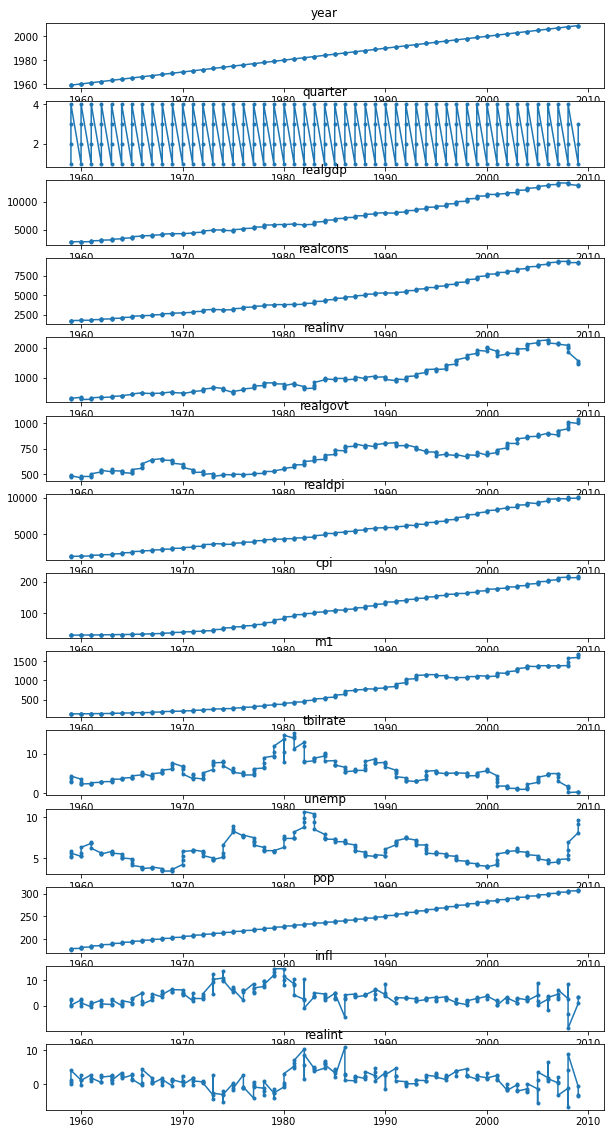

In [10]:
# 時間推移のグラフ

x = macro_data["year"]
columns_li = macro_data.columns
fig = plt.figure(figsize=(10, 20))
for i, index in enumerate(columns_li):
    y = macro_data[index]
    ax = fig.add_subplot(len(columns_li), 1, i+1)

    ax.plot(x, y, marker=".")
    plt.title(index)

plt.show()

In [15]:
# 使用するデータのみ抽出して、整形
macro_data['year'] = macro_data['year'].astype(int)

macro_data.index = pd.date_range(
    str(macro_data['year'].min()), 
    periods=len(macro_data), 
    freq='Q'
)
target_data = macro_data[['realgdp', 'realcons', 'realinv']]

print(macro_data.shape)

(203, 14)


realgdb：実質国内総生産  
realcons：実質個人消費支出  
realinv：実質国内総投資

# 可視化

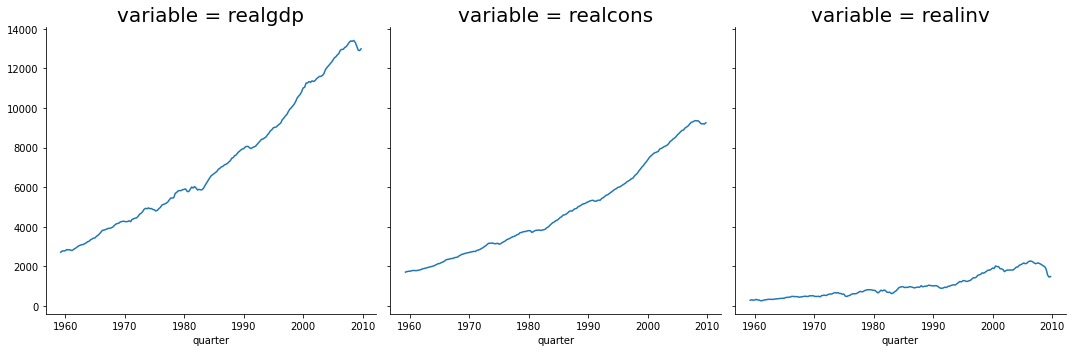

In [13]:
# 時間推移のグラフ
plot_data = target_data.stack()
plot_data = plot_data.reset_index()
plot_data.columns = ['quarter', 'variable', 'value']

g = sns.relplot(
    data=plot_data,
    x='quarter',
    y='value',
    col='variable',
    kind='line'
)
g.set_axis_labels('quarter', '').set_titles(size=20).tight_layout()
g.savefig(result_dir_path.joinpath('macro_data_plot.png'))
g

# 単位根過程の検定(ADF検定)

In [14]:
adf = stattools.adfuller(target_data['realgdp'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -2.23, p値 : 71.5%
データ数 : 190, 使用されたラグ数 : 12
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [16]:
adf = stattools.adfuller(target_data['realcons'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -3.01, p値 : 29.1%
データ数 : 199, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [17]:
adf = stattools.adfuller(target_data['realinv'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -1.63, p値 : 92.3%
データ数 : 199, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


# 1次の階差をとって、単位根過程の検定

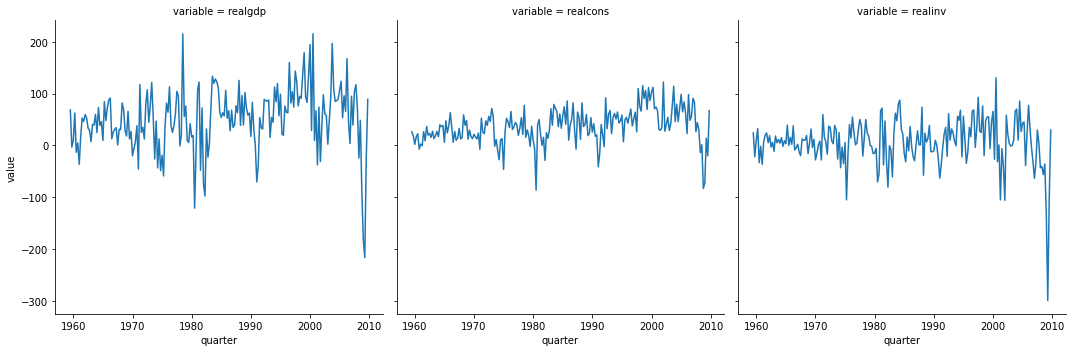

In [19]:
target_data_diff = target_data.diff().dropna()

plot_data = target_data_diff.stack()
plot_data = plot_data.reset_index()
plot_data.columns = ['quarter', 'variable', 'value']

sns.relplot(
    data=plot_data,
    x='quarter',
    y='value',
    col='variable',
    kind='line'
)

In [22]:
adf = stattools.adfuller(target_data_diff['realgdp'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -4.26, p値 : 1.4%
データ数 : 190, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [23]:
adf = stattools.adfuller(target_data_diff['realcons'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -4.66, p値 : 0.4%
データ数 : 198, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [24]:
adf = stattools.adfuller(target_data_diff['realinv'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -10.37, p値 : 0.0%
データ数 : 201, 使用されたラグ数 : 0
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


# モデリング

In [25]:
learning_data = target_data.diff().dropna()

model = VAR(learning_data)

In [26]:
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,21.03,21.08,1.358e+09,21.05
1,20.39,20.60*,7.159e+08,20.47
2,20.37,20.73,7.031e+08,20.52
3,20.26*,20.78,6.282e+08*,20.47*
4,20.30,20.97,6.544e+08,20.57
5,20.32,21.15,6.694e+08,20.66
6,20.34,21.32,6.801e+08,20.73
7,20.37,21.51,7.070e+08,20.84
8,20.39,21.68,7.180e+08,20.91
9,20.39,21.85,7.251e+08,20.98


In [27]:
model_result = model.fit(maxlags=15, ic='aic')
model_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Jan, 2023
Time:                     02:18:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.6099
Nobs:                     199.000    HQIC:                   20.3144
Log likelihood:          -2818.40    FPE:                5.43599e+08
AIC:                      20.1135    Det(Omega_mle):     4.69244e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              12.638159         7.157543            1.766           0.077
L1.realgdp         -0.393119         0.151899           -2.588           0.010
L1.realcons         1.173272         0.192878            6.083    

# 推定

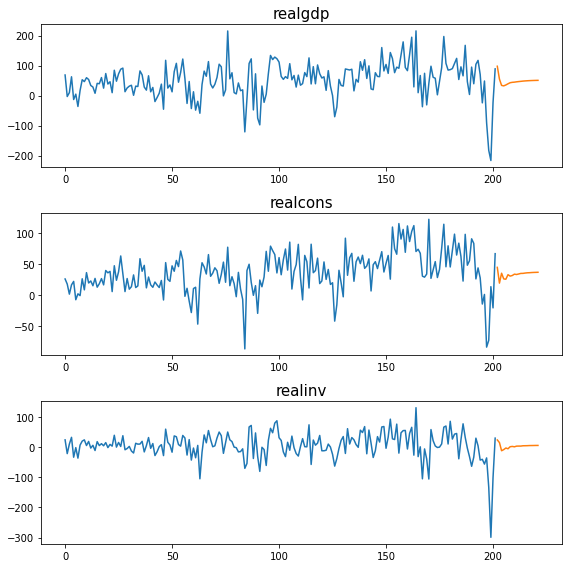

In [28]:
steps = 20
result = model_result.forecast(model_result.endog, steps=steps)

fig = plt.figure(i, figsize=(8, 8))
for i, variable_name in enumerate(['realgdp', 'realcons', 'realinv']):
    
    ax = fig.add_subplot(3, 1, i+1)
    y = model_result.endog[:, i]
    ax.plot(
        np.arange(len(y)),
        y
    )
    ax.plot(
        np.arange(len(y), len(y)+steps),
        result[:, i]
    )
    ax.set_title(variable_name, size=15)
    
fig.tight_layout()
plt.savefig(result_dir_path.joinpath('micro_data_predict.png'))

# 予測分散分解

In [30]:
fevd_result = model_result.fevd(20)
fevd_result.summary()

FEVD for realgdp
       realgdp  realcons   realinv
0     1.000000  0.000000  0.000000
1     0.819493  0.156609  0.023898
2     0.745594  0.225750  0.028656
3     0.692096  0.263537  0.044367
4     0.663116  0.281238  0.055646
5     0.646708  0.288258  0.065034
6     0.636706  0.290706  0.072588
7     0.629012  0.292737  0.078252
8     0.623998  0.293654  0.082349
9     0.620499  0.294067  0.085434
10    0.618095  0.294313  0.087592
11    0.616529  0.294352  0.089119
12    0.615498  0.294322  0.090180
13    0.614810  0.294291  0.090899
14    0.614367  0.294248  0.091386
15    0.614078  0.294212  0.091711
16    0.613890  0.294185  0.091925
17    0.613770  0.294164  0.092066
18    0.613694  0.294149  0.092157
19    0.613646  0.294139  0.092216

FEVD for realcons
       realgdp  realcons   realinv
0     0.251170  0.748830  0.000000
1     0.232511  0.741561  0.025928
2     0.210884  0.746999  0.042117
3     0.178346  0.769495  0.052159
4     0.173118  0.758167  0.068715
5     0.167338  0.7

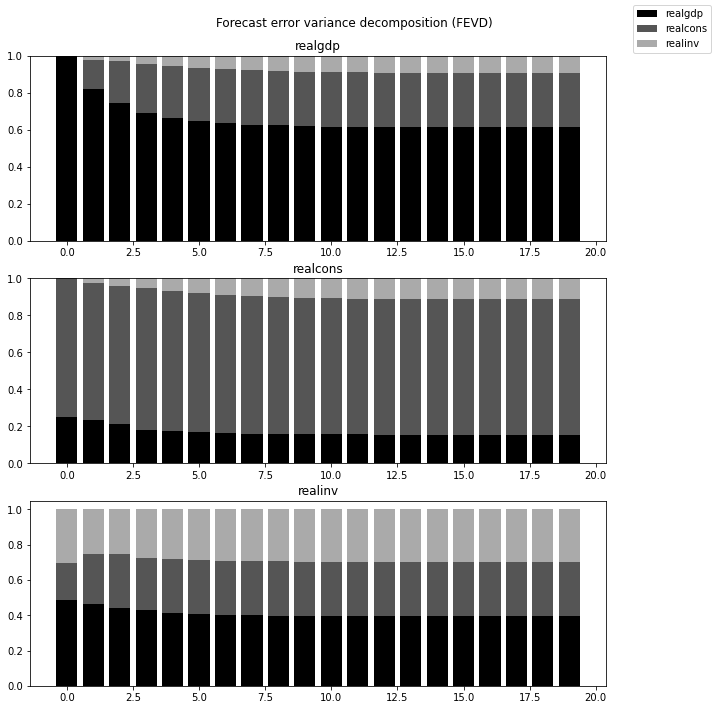

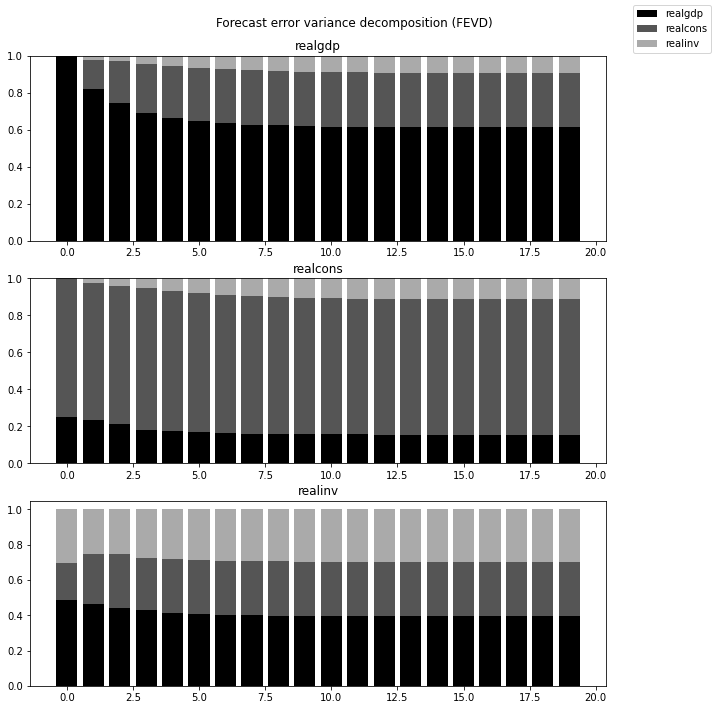

In [31]:
fevd_result.plot()

- 実質国内総生産の予測は、短期的には直近の自身の値に影響され、長期的には実質個人消費の影響を若干受ける  
- 実質個人消費の予測は、短期か長期かに関わらず自身の影響を強く受け、若干実質国内総生産の影響を受ける  
- 実質国内総投資の予測は、短期か長期かに関わらず自身の影響が低く、実質国内総生産、実質個人消費の両方から影響を受ける

# インパルス応答関数

## モデル再構築

In [33]:
macro_data['year'] = macro_data['year'].astype(int)

macro_data.index = pd.date_range(
    str(macro_data['year'].min()), 
    periods=len(macro_data), 
    freq='Q'
)
columns = ['realgdp', 'realcons', 'realinv']
target_data = macro_data[columns].copy()

target_data = np.log(target_data) - np.log(target_data.shift(1))
target_data.dropna(inplace=True)
target_data *= 100

In [34]:
model = VAR(target_data)
model_result = model.fit(maxlags=15, ic='aic')
model_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Jan, 2023
Time:                     03:34:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.205328
Nobs:                     199.000    HQIC:                -0.0902127
Log likelihood:          -788.137    FPE:                   0.747593
AIC:                    -0.291150    Det(Omega_mle):        0.645336
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.128149         0.129527            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

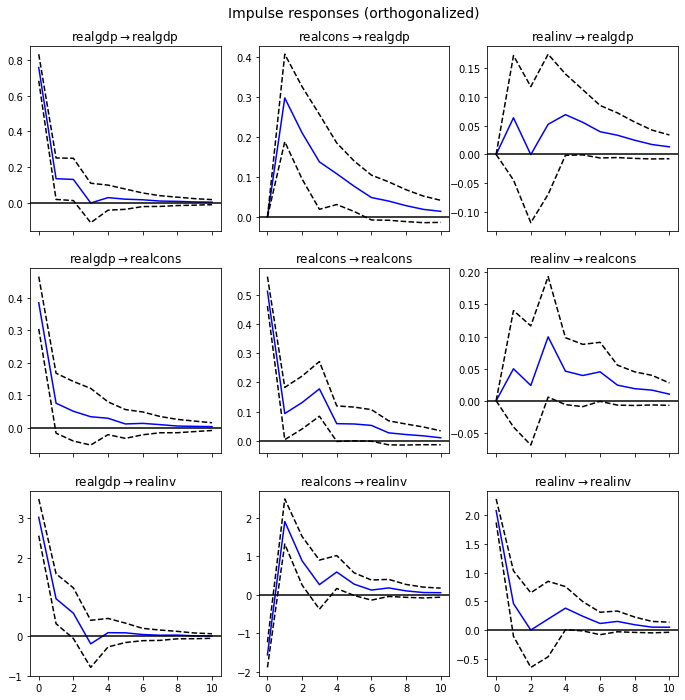

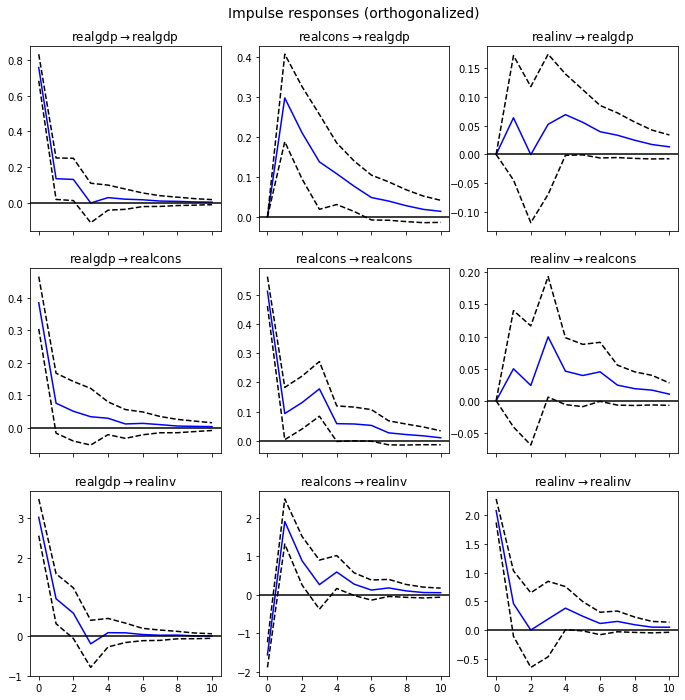

In [35]:
irf = model_result.irf(10)
irf.plot(orth=True)

- 国内総生産の1%の増加において、直近の変化が一番大きいのは国内総投資であり、同時期には3%増加。ただし、１クオーター先までは影響あるが、その後の影響は少ない  
- 個人消費支出の1.24%の増加において、国内総生産は１クオーター先で0.4%増加するが、その後は影響がなくなっていく。国内総投資に対しては、同時期に-1.56%の影響だが、１クオーター先では1.96%の増加
- 国内総投資の1.92%の増加において、他の変数への影響は小さい

ざっくりまとめると、個人消費が増えたときに１クオーター遅れて、国内総生産と投資が増加するようですね。また、国内総生産が増加すると、１クオーター先の個人消費が上がるという結果ですが、個人消費が国内総生産を支えているという関係性から、国内総生産が上がっている状態だと、１クオーター後も個人消費が増加する状態が続くと解釈することが良さそうですね。



In [36]:
# 直行化インパルス応答関数における分解した撹乱項の標準偏差

sigma = model_result.sigma_u

L = np.linalg.cholesky(sigma)
L_inv = np.linalg.inv(L)
L_t_inv = np.linalg.inv(L.T)
D = L_inv * sigma * L_t_inv

new_sigma_sqrt = np.sqrt(np.diag(D))
new_sigma_sqrt

array([1.        , 1.24988005, 1.92380124])